<a href="https://colab.research.google.com/github/bleenee203/IS335.P11---SQLi/blob/kthanh/Word2vec_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf

# Mount drive and load data
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
data_path = '/content/drive/My Drive/Data/Modified_SQL_Dataset_preprocessed.csv'
data = pd.read_csv(data_path)

# Preprocess the Query data
data['Query'] = data['Query'].fillna('').apply(str)
queries = data['Query'].apply(lambda x: x.lower().split())
labels = data['Label'].values
y = labels  # Assign labels to y

# Step 2: Train Word2Vec Model
from gensim.models import Word2Vec
word2vec_model = Word2Vec(sentences=queries, vector_size=200, min_count=1, window=5, sg=1)

# Save word embeddings to use in LSTM
vocab_size = len(word2vec_model.wv)
embedding_dim = word2vec_model.vector_size

# Step 3: Prepare Data for LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Query'])
sequences = tokenizer.texts_to_sequences(data['Query'])

# Padding sequences to ensure consistent input shape for LSTM
max_sequence_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Map Word2Vec embeddings to Keras Embedding layer
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Step 4: Build the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

batch_sizes = [16, 32, 64, 128]
best_batch_size = None
best_accuracy = 0

for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X, y, epochs=10, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    val_accuracy = max(history.history['val_accuracy'])
    print(f"Validation Accuracy: {val_accuracy}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_batch_size = batch_size

print(f"Best Batch Size: {best_batch_size}, Best Validation Accuracy: {best_accuracy}")


Mounted at /content/drive
Training with batch size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation Accuracy: 1.0
Training with batch size: 32
Validation Accuracy: 0.9983829259872437
Training with batch size: 64
Validation Accuracy: 0.9987063407897949
Training with batch size: 128
Validation Accuracy: 0.9990297555923462
Best Batch Size: 16, Best Validation Accuracy: 1.0


Epoch 1/20
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.9774 - loss: 0.0801 - val_accuracy: 0.9984 - val_loss: 0.0046
Epoch 2/20
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9854 - loss: 0.0548 - val_accuracy: 0.9981 - val_loss: 0.0080
Epoch 3/20
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9873 - loss: 0.0485 - val_accuracy: 0.9985 - val_loss: 0.0051
Epoch 4/20
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9881 - loss: 0.0469 - val_accuracy: 0.9982 - val_loss: 0.0071


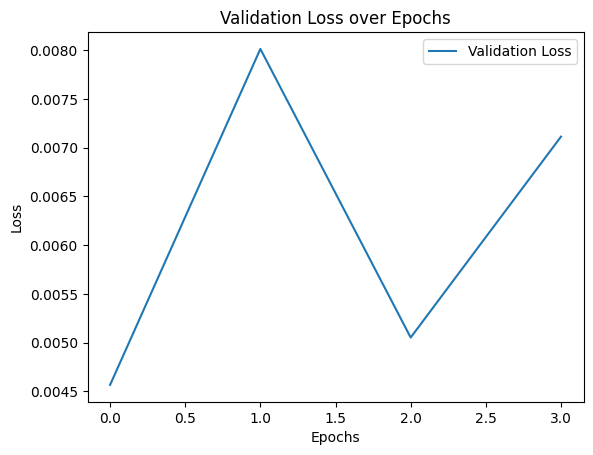

Best Epoch: 1


In [2]:

# Using the best batch size found earlier
batch_size = best_batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X, y, epochs=20, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

# Plot validation loss to find the optimal epoch
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss over Epochs')
plt.show()

# Find the best epoch
best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
print(f"Best Epoch: {best_epoch}")


In [3]:
from sklearn.metrics import classification_report

# Step 1: Get model predictions on the validation/test set
y_pred = (model.predict(X) > 0.5).astype("int32")  # Use a threshold of 0.5 for binary classification

# Step 2: Print Precision, Recall, and F1-Score
print(classification_report(y, y_pred, target_names=['Non-SQL Injection', 'SQL Injection']))


967/967 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
                   precision    recall  f1-score   support

Non-SQL Injection       0.99      1.00      0.99     19537
    SQL Injection       0.99      0.98      0.99     11382

         accuracy                           0.99     30919
        macro avg       0.99      0.99      0.99     30919
     weighted avg       0.99      0.99      0.99     30919



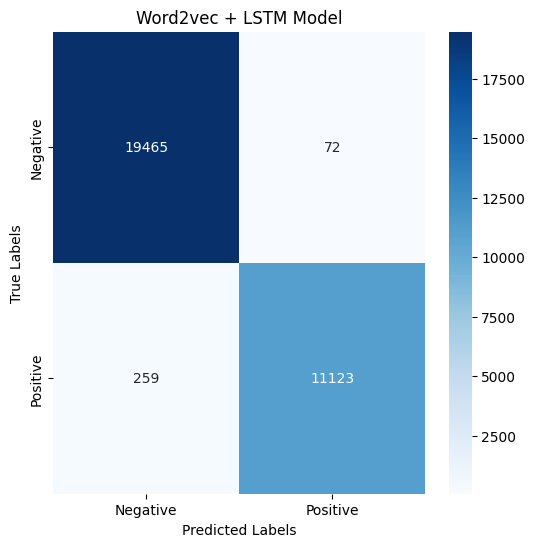

In [6]:


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_class = (y_pred > 0.5).astype(int)  # Nếu xác suất > 0.5 thì là lớp 1, nếu <= 0.5 thì là lớp 0

# 3. Tính toán Confusion Matrix
cm = confusion_matrix(y, y_pred_class)

# 4. Vẽ Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Word2vec + LSTM Model')
plt.show()

In [7]:
# Lưu model để chạy thực nghiệm
model.save("lstm.h5")